# Getting the Data for a Bay Area Transit Flow Animation

This notebook will walk through downloading, cleaning and wrangling transit schedule data from Mapzen's [Transitland API](https://transit.land/) so that we can visualize it using Processing. Transitland ingests [General Transit Feed Specificaiton (GTFS)](https://en.wikipedia.org/wiki/General_Transit_Feed_Specification) data from transit operators around the world, processes and validates it, and serves it up with an open-source, free API.

### Inputs

Sign up for a [Mapzen API key](https://mapzen.com/developers/sign_up) if you don't already have one.

In [2]:
date = "2017-07-17"
mapzen_api_key = "mapzen-ai1duha"
name = r"bay_area" # this determines how to name output csv files

### Define bounding box

Using bboxfinder: http://bboxfinder.com/#37.011326,-123.280334,38.955137,-120.607910

In [3]:
south, west, north, east = 37.011326,-123.280334,38.955137,-120.607910

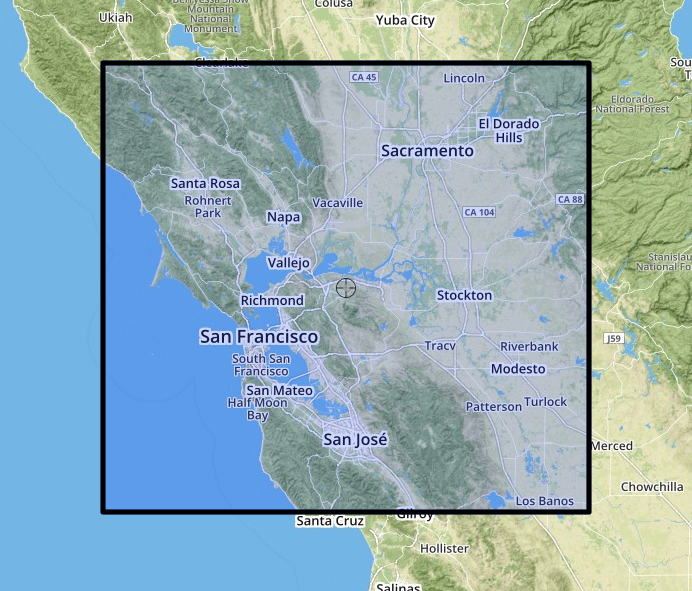

In [4]:
from IPython.display import Image
Image("http://i.imgur.com/QoyEwFm.png")

### Import python libraries

In [ ]:
import requests
import pandas as pd
import numpy as np
import datetime as dt
import glob
import os

### Define some helper functions

This is a helper function to paginate through Transitland api responses with multiple pages.

In [ ]:
def transitland_request(url):
    next_url = url
    while next_url:
        # next url in 'meta'
        data = requests.get(next_url).json()
        meta = data.get('meta', {})
        next_url = meta.get('next')
        # transitland responses will have one main key that isn't "meta"
        main_key = (set(data.keys()) - set(['meta'])).pop()
        for item in data[main_key]:
            yield item

This function will get all **vehicle types** for an operator, by route. So we can ask *"what vehicle type is this particular trip?"* and color code trips by vehicle type. 

In [ ]:
def get_vehicle_types(operator_onestop_id):
    routes_url = "http://transit.land/api/v1/routes?operated_by={}&per_page=1000&api_key={}".format(operator_onestop_id, mapzen_api_key)
    lookup_vehicle_types = {i['onestop_id']: i['vehicle_type'] for i in transitland_request(routes_url)}
    return lookup_vehicle_types

Here are the possible vehicle types: (Source: [Google](https://github.com/google/transit/blob/master/gtfs/spec/en/reference.md#routestxt))

In [ ]:
Image("http://i.imgur.com/Z9FPIdI.png")

These functions get all stop lats and lons for a particular operator.

In [ ]:
def get_stop_lats(operator_onestop_id):
    stops_url = "http://transit.land/api/v1/stops?served_by={}&per_page=1000&api_key={}".format(operator_onestop_id, mapzen_api_key)
    lookup_stop_lats = {i['onestop_id']: i['geometry']['coordinates'][1] for i in transitland_request(stops_url)}
    return lookup_stop_lats

In [ ]:
def get_stop_lons(operator_onestop_id):
    stops_url = "http://transit.land/api/v1/stops?served_by={}&per_page=1000&api_key={}".format(operator_onestop_id, mapzen_api_key)
    lookup_stop_lons = {i['onestop_id']: i['geometry']['coordinates'][0] for i in transitland_request(stops_url)}
    return lookup_stop_lons

This function gets origin-destination pairs and timestamps from the schedule stop pairs API. This is the most important function and the largest API request. 

In [ ]:
def get_schedule_stop_pairs(operator_onestop_id, date):
    schedule_stop_pairs_url = "http://transit.land/api/v1/schedule_stop_pairs?date={}&operator_onestop_id={}&per_page=1000&api_key={}".format(date, operator_onestop_id, mapzen_api_key)    
    print schedule_stop_pairs_url
    origin_times = []
    destination_times = []
    origin_stops = []
    destination_stops = []
    route_ids = []
    count=0
    for i in transitland_request(schedule_stop_pairs_url):
        count+=1
        if count % 10000 == 0:
            print count
        origin_times.append(i['origin_departure_time'])
        destination_times.append(i['destination_arrival_time'])
        origin_stops.append(i['origin_onestop_id'])
        destination_stops.append(i['destination_onestop_id'])
        route_ids.append(i['route_onestop_id'])
        
    return origin_times, destination_times, origin_stops, destination_stops, route_ids

This function calculates durations between origin and destination pairs (in seconds).

In [ ]:
def calculate_durations(origin_times, destination_times):
    origin_since_epoch = [int(i.split(':')[0])*60*60 + int(i.split(':')[1])*60 + int(i.split(':')[2]) for i in origin_times]
    destination_since_epoch = [int(i.split(':')[0])*60*60 + int(i.split(':')[1])*60 + int(i.split(':')[2]) for i in destination_times]
    durations = [b - a for a, b in zip(origin_since_epoch, destination_since_epoch)]
    return durations

This function cleans origin and destination times. This is a bit tricky because operators will often include non-real times such as "26:00:00" to indicate 2am the next day.

In [ ]:
def clean_times(origin_times, destination_times):
    # Modulo away the > 24 hours
    origin_times_clean = [":".join([str(int(i.split(':')[0]) % 24), i.split(':')[1], i.split(':')[2]]) for i in origin_times]
    destination_times_clean = [":".join([str(int(i.split(':')[0]) % 24), i.split(':')[1], i.split(':')[2]]) for i in destination_times]
    return origin_times_clean, destination_times_clean

This function appends destination and origin dates to times, so that times become datetimes.

In [ ]:
def add_dates(date, origin_times_clean, destination_times_clean):
    
    date1 = dt.datetime.strptime(date, "%Y-%m-%d").date()
    date2 = date1 + dt.timedelta(days=1)
    
    origin_datetimes = []
    destination_datetimes = []
    
    for i in range(len(origin_times_clean)):
        if int(destination_times_clean[i].split(":")[0]) < int(origin_times_clean[i].split(":")[0]):
            origin_datetime = str(date1) + " " + origin_times_clean[i]
            destination_datetime = str(date2) + " " + destination_times_clean[i]
        else:
            origin_datetime = str(date1) + " " + origin_times_clean[i]
            destination_datetime = str(date1) + " " + destination_times_clean[i]
          
        origin_datetimes.append(origin_datetime)
        destination_datetimes.append(destination_datetime)
    
    return origin_datetimes, destination_datetimes

This function generates the output table, to be saved later as a csv.

In [ ]:
def generate_output(operator_onestop_id, origin_datetimes, destination_datetimes, durations, origin_stops, destination_stops, route_ids, lookup_stop_lats, lookup_stop_lons, lookup_vehicle_types):
    
    origin_stop_lats = [lookup_stop_lats[i] for i in origin_stops]
    origin_stop_lons = [lookup_stop_lons[i] for i in origin_stops]
    destination_stop_lats = [lookup_stop_lats[i] for i in destination_stops]
    destination_stop_lons = [lookup_stop_lons[i] for i in destination_stops]
    vehicle_types = []
    for i in route_ids:
        try:
            vehicle_type = lookup_vehicle_types[i]
            vehicle_types.append(vehicle_type)
        except:
            vehicle_types.append("NA")
    
    output = pd.DataFrame({
        'route_type': vehicle_types,
        'start_time': origin_datetimes,
        'start_lat': origin_stop_lats,
        'start_lon': origin_stop_lons,
        'end_time': destination_datetimes,
        'end_lat': destination_stop_lats,
        'end_lon': destination_stop_lons,
        'duration': durations
    })
    output = output[['start_time', 'start_lat', 'start_lon', 'end_time', 'end_lat', 'end_lon', 'duration', 'route_type']]
    return output

This is the main function that ties all of the above together!

In [ ]:
def animate_one_day(operator_onestop_id, date):
    
    lookup_vehicle_types = get_vehicle_types(operator_onestop_id)
    lookup_stop_lats = get_stop_lats(operator_onestop_id)
    lookup_stop_lons = get_stop_lons(operator_onestop_id)
    origin_times, destination_times, origin_stops, destination_stops, route_ids = get_schedule_stop_pairs(operator_onestop_id, date)
    durations = calculate_durations(origin_times, destination_times)
    origin_times_clean, destination_times_clean = clean_times(origin_times, destination_times)
    origin_datetimes, destination_datetimes = add_dates(date, origin_times_clean, destination_times_clean)
    output = generate_output(operator_onestop_id, origin_datetimes, destination_datetimes, durations, origin_stops, destination_stops, route_ids, lookup_stop_lats, lookup_stop_lons, lookup_vehicle_types)
    output = output.sort_values(by='start_time').reset_index(drop=True)
    
    return output

### With those helper functions defined, let's get the data for the Bay Area!

First, let's get a list of the onestop id's for every operator in our bounding box.

In [ ]:
operators_url = "http://transit.land/api/v1/operators?bbox={},{},{},{}&per_page=1000&api_key={}".format(west, south, east, north, mapzen_api_key)
operators_in_bbox = [i['onestop_id'] for i in transitland_request(operators_url)]

In [ ]:
print len(operators_in_bbox), "operators in bounding box."

We will exclude national Amtrak trips from the visualizaiton and vehicle counts.

In [ ]:
operators_in_bbox.remove('o-9-amtrak')
print len(operators_in_bbox), "operators in bounding box."

### Run script on every operator and save each operator's results to a separate csv

In [ ]:
def animate_many_operators(operators, date):

    starttime = dt.datetime.now()
    print starttime
    
    results = []
    failures = []

    length = len(operators)
    count = 1

    for i in operators:
        print i, count, "/", length
        try:
            output = animate_one_day(i, date)
            results.append(output)
            output.to_csv("data/indiv_operators/{}.csv".format(i))
        except:
            failures.append(i)
            print "failed"
        count += 1
        
    endtime = dt.datetime.now()
    print endtime
    print "Time taken:", endtime - starttime
    
    return results, failures

In [ ]:
results, failures = animate_many_operators(operators_in_bbox, date)

In [ ]:
print len(results), "operators successfully downloaded."

In [ ]:
print len(failures), "operators failed."

In [ ]:
if len(failures): print "failed operators:", failures

### Concatenate all individual operator csv files into one big dataframe

In [ ]:
def concatenate_csvs(path):
    all_files = glob.glob(os.path.join(path, "*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
    df_from_each_file = (pd.read_csv(f) for f in all_files) # generators
    concatenated_df   = pd.concat(df_from_each_file, ignore_index=True)
    del concatenated_df['Unnamed: 0'] # delete the blank column that gets added
    concatenated_df['start_time'] = pd.to_datetime(concatenated_df['start_time'])
    concatenated_df['end_time'] = pd.to_datetime(concatenated_df['end_time'])
    concatenated_df = concatenated_df.sort_values(by="start_time").reset_index(drop=True)
    return concatenated_df

In [ ]:
concatenated_df = concatenate_csvs("data/indiv_operators")

In [ ]:
concatenated_df.head()

In [ ]:
concatenated_df.to_csv("data/output/{}.csv".format(name))

In [ ]:
print concatenated_df.shape

### That's it for the trip data!

### Next step:  Count number of vehicles in transit at every 15 second interval

In order to add a stacked area chart to the animation showing the number of vehicles on the road, we will do some counting here in python and save the results in six separate csv files (one for each mode of transit in SF Bay Area: bus, tram, cablecar, metro, rail, ferry. The Processing sketch will read in each file and use them to plot a stacked area chart.

Vehicle counting logic: 

At any given time $t$, every vehicle on the road will have started its current trip before $t$ and will end its current trip after $t$. So we can filter our data by end time and start time to calculate the number of vehicles scheduled to be on the road at any given time. We will be inclusive on the start date but exclusive on the end date to avoid double counting a trip -- i.e. if a trip starts at 10:00am then it is "on the road" at 10:00am, but if a trip ends at 10:15am, then it is not considered "on the road" at 10:15am. This way, we avoid double counting vehicles.

In [ ]:
def count_vehicles_on_screen(concatenated_df, date):
    number_of_vehicles = []
    number_of_buses = []
    number_of_trams = []
    number_of_cablecars = []
    number_of_metros = []
    number_of_trains = []
    number_of_ferries = []
    
    day = dt.datetime.strptime(date, "%Y-%m-%d")
    thisday = dt.datetime.strftime(day, "%Y-%m-%d")

    # Every minute in the day
    the_day = [pd.to_datetime(thisday) + dt.timedelta(seconds = i*15) for i in range(60 * 24 * 4)]

    count = 0
    for minute in the_day:
        
        vehicles_on_the_road = concatenated_df[(concatenated_df['end_time'] > minute) & (concatenated_df['start_time'] <= minute)]
        number_vehicles_on_the_road = len(vehicles_on_the_road)
        number_of_vehicles.append(number_vehicles_on_the_road)

        for route_type in ['bus', 'tram', 'cablecar', 'metro', 'rail', 'ferry']:
            just_this_mode = vehicles_on_the_road[vehicles_on_the_road['route_type'] == route_type]
            number_of_this_mode = len(just_this_mode)
            if route_type == 'bus':
                number_of_buses.append(number_of_this_mode)
            elif route_type == 'tram':
                number_of_trams.append(number_of_this_mode)
            elif route_type == 'cablecar':
                number_of_cablecars.append(number_of_this_mode)
            elif route_type == 'metro':
                number_of_metros.append(number_of_this_mode)
            elif route_type == 'rail':
                number_of_trains.append(number_of_this_mode)
            elif route_type == 'ferry':
                number_of_ferries.append(number_of_this_mode)

        if count % (60*4) == 0:
            print minute
        
        count += 1

    vehicles = pd.DataFrame(zip(the_day, number_of_vehicles))
    buses = pd.DataFrame(zip(the_day, number_of_buses))
    trams = pd.DataFrame(zip(the_day, number_of_trams))
    cablecars = pd.DataFrame(zip(the_day, number_of_cablecars))
    metros = pd.DataFrame(zip(the_day, number_of_metros))
    trains = pd.DataFrame(zip(the_day, number_of_trains))
    ferries = pd.DataFrame(zip(the_day, number_of_ferries))
    
    for df in [vehicles, buses, trams, metros, cablecars, trains, ferries]:
        df.columns = ['time', 'count']

    return vehicles, buses, trams, metros, cablecars, trains, ferries

In [ ]:
vehicles, buses, trams, metros, cablecars, trains, ferries = count_vehicles_on_screen(concatenated_df, date)

### Save vehicle counts to csv (3600 frame version)

Our Processing sketch has 3,600 frames (at 60 frames per second makes a one minute video). One day has 5,760 15-second intervals. So to make things easy we will select the vehicle counts at 3,600 of the 15-second intervals throughout the day. We will select them randomly, but will maintain chronological order by sorting and also consistency between vehicle types by using a consitent set of random indices to select counts for different vehicle types.

In [ ]:
frames = 3600
random_indices = np.sort(np.random.choice(vehicles.index, frames, replace=False))

In [ ]:
vehicles_counts_output = vehicles.loc[random_indices].reset_index(drop=True)
vehicles_counts_output['frame'] = vehicles_counts_output.index

buses_counts_output = buses.loc[random_indices].reset_index(drop=True)
buses_counts_output['frame'] = buses_counts_output.index

trams_counts_output = trams.loc[random_indices].reset_index(drop=True)
trams_counts_output['frame'] = trams_counts_output.index

metros_counts_output = metros.loc[random_indices].reset_index(drop=True)
metros_counts_output['frame'] = metros_counts_output.index

cablecars_counts_output = cablecars.loc[random_indices].reset_index(drop=True)
cablecars_counts_output['frame'] = cablecars_counts_output.index

trains_counts_output = trains.loc[random_indices].reset_index(drop=True)
trains_counts_output['frame'] = trains_counts_output.index

ferries_counts_output = ferries.loc[random_indices].reset_index(drop=True)
ferries_counts_output['frame'] = ferries_counts_output.index

Save these vehicle count stats to csv's.

In [ ]:
vehicles_counts_output.to_csv("data/output/{}_vehicles_count_3600.csv".format(name))
buses_counts_output.to_csv("data/output/{}_buses_count_3600.csv".format(name))
trams_counts_output.to_csv("data/output/{}_trams_count_3600.csv".format(name))
metros_counts_output.to_csv("data/output/{}_metros_count_3600.csv".format(name))
cablecars_counts_output.to_csv("data/output/{}_cablecars_count_3600.csv".format(name))
trains_counts_output.to_csv("data/output/{}_trains_count_3600.csv".format(name))
ferries_counts_output.to_csv("data/output/{}_ferries_count_3600.csv".format(name))

### Save vehicle counts to csv (900 frame version)

You may want to make a faster, 15-second long animation using only 900 frames. This can be especially helpful when developing or debugging. So, repeat the same thing for 900 frames and save to separate csv files to give yourself this option.

In [ ]:
frames = 900
random_indices = np.sort(np.random.choice(vehicles.index, frames, replace=False))

In [ ]:
vehicles_counts_output = vehicles.loc[random_indices].reset_index(drop=True)
vehicles_counts_output['frame'] = vehicles_counts_output.index

buses_counts_output = buses.loc[random_indices].reset_index(drop=True)
buses_counts_output['frame'] = buses_counts_output.index

trams_counts_output = trams.loc[random_indices].reset_index(drop=True)
trams_counts_output['frame'] = trams_counts_output.index

metros_counts_output = metros.loc[random_indices].reset_index(drop=True)
metros_counts_output['frame'] = metros_counts_output.index

cablecars_counts_output = cablecars.loc[random_indices].reset_index(drop=True)
cablecars_counts_output['frame'] = cablecars_counts_output.index

trains_counts_output = trains.loc[random_indices].reset_index(drop=True)
trains_counts_output['frame'] = trains_counts_output.index

ferries_counts_output = ferries.loc[random_indices].reset_index(drop=True)
ferries_counts_output['frame'] = ferries_counts_output.index

In [ ]:
vehicles_counts_output.to_csv("data/output/{}_vehicles_count_900.csv".format(name))
buses_counts_output.to_csv("data/output/{}_buses_count_900.csv".format(name))
trams_counts_output.to_csv("data/output/{}_trams_count_900.csv".format(name))
metros_counts_output.to_csv("data/output/{}_metros_count_900.csv".format(name))
cablecars_counts_output.to_csv("data/output/{}_cablecars_count_900.csv".format(name))
trains_counts_output.to_csv("data/output/{}_trains_count_900.csv".format(name))
ferries_counts_output.to_csv("data/output/{}_ferries_count_900.csv".format(name))

### Optional: Interactive plot showing the number of vehicles on the road

In [ ]:
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
%matplotlib inline

In [ ]:
# A list of times at every 15 second interval throughout the day
the_day = [pd.to_datetime(date) + dt.timedelta(seconds=i*15) for i in range(60 * 24 * 4)]

In [ ]:
df = pd.DataFrame({
    'time': the_day,
    'total': vehicles['count'],
    'buses': buses['count'],
    'trams': trams['count'],
    'metros': metros['count'],
    'cablecars': cablecars['count'],
    'train': trains['count'],
    'ferries': ferries['count']
})

Visualize with plotly.

In [ ]:
def make_stacked_area_plot(df):

    bus = go.Bar(
        x=df['time'],
        y=df['buses'],
        name='Bus'
    )
    tram = go.Bar(
        x=df['time'],
        y=df['trams'],
        name='Tram'
    )
    metro = go.Bar(
        x=df['time'],
        y=df['metros'],
        name='Metro'
    )
    train = go.Bar(
        x=df['time'],
        y=df['train'],
        name='Train'
    )
    cablecar = go.Bar(
        x=df['time'],
        y=df['cablecars'],
        name='Cable Cars'
    )
    
    ferry = go.Bar(
        x=df['time'],
        y=df['ferries'],
        name='Ferry'
    )

    data = [bus, train, tram, metro, cablecar, ferry]
    layout = go.Layout(
        barmode='stack',
        title="Number of Public Transit Vehicles Scheduled to be on the Road in the Bay Area on a Typical Monday",
        xaxis=dict(
            title='Time of Day',
            titlefont=dict(
                size=18,
                color='#7f7f7f'
            )
        ),
        yaxis=dict(
            title='Number of Vehicles',
            titlefont=dict(
                size=18,
                color='#7f7f7f'
            )
        )
    )

    fig = go.Figure(data=data, layout=layout)
    return py.iplot(fig, filename='stacked-bar')

In [ ]:
make_stacked_area_plot(df)